In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

from scikeras.wrappers import KerasRegressor

import math

# Reading train and test datasets

In [49]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [50]:
def remove_outliers(df, quantile=0.05):
    Q1 = df.quantile(quantile)
    Q3 = df.quantile(1-quantile)
    IQR = Q3 - Q1
    
    return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

def apply_feature_engineering(df: pd.DataFrame, keep_outliers) -> pd.DataFrame:
    df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].mean())
    custom_encoding = {"ISLAND": 4, "NEAR OCEAN": 3, "NEAR BAY": 2, "<1H OCEAN": 1, "INLAND": 0}
    df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]
    df = df.drop("ocean_proximity", axis=1)
    df["rooms_per_bedroom"] = df["total_rooms"] / df["total_bedrooms"]
    df["rooms_per_household"] = df["total_rooms"] / df["households"]
    df["encoded_position"] = df["longitude"] + df["latitude"]
    df["population_per_bedrooms"] = df["population"] / df["total_bedrooms"]
    df["target"] = df["median_house_value"]
    df = df.drop("median_house_value", axis=1)
    if not keep_outliers:
        df = remove_outliers(df, 0.05)
    return df

In [51]:
df_train = apply_feature_engineering(df_train, True)
df_test = apply_feature_engineering(df_test, False)

X_train = df_train.drop("target", axis=1)
y_train = df_train["target"]

X_test = df_test.drop("target", axis=1)
y_test = df_test["target"]

/tmp/ipykernel_27161/285434561.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]
/tmp/ipykernel_27161/285434561.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]


# Baseline

In [52]:
pipe = Pipeline([])
pipe.steps.append(("scaler", StandardScaler()))
pipe.steps.append(("reg", LinearRegression()))
pipe.fit(X_train, y_train)

y_predict = pipe.predict(X_test)
metrics.root_mean_squared_error(y_test, y_predict)

69078.54857545583

In [53]:
def plot_rmse(history):
    loss = np.sqrt(history["loss"])
    val_loss = np.sqrt(history["val_loss"])
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel("Epoch")

def rmse(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.square(y_pred - y_true))**0.5

# Training

In [54]:
def build_model(inputs: int,
                layers: list[int],
                layers_per_dropout: int = 0,
                dropout_rate: int = 0,
                activation_func = "relu",
                loss_func = "mean_squared_error",
                optimizer = "adam"):
    
    model = Sequential()
    model.add(Input((inputs, )))
    count = 0
    for n_nodes in layers:
        model.add(Dense(n_nodes, activation=activation_func))
        count += 1
        if layers_per_dropout == count:
            model.add(Dropout(dropout_rate))
            count == 0

    model.add(Dense(1))
    
    model.compile(optimizer=optimizer, loss=loss_func, metrics=[rmse])
    return model

def build_keras_regressor(model,
                          epochs = 100,
                          batch_size = 100,
                          verbose = 0,
                          patience = None):
    if patience is not None:
        early_stop = EarlyStopping(patience = patience, restore_best_weights = True)
        callbacks = [early_stop]
    else:
        callbacks = []
    return KerasRegressor(model=model,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=verbose,
                          callbacks=callbacks)

In [55]:
pipe = Pipeline([])
pipe.steps.append(("scaler", StandardScaler()))

pipe.fit(X_train)
X_test_transformed = pipe.transform(X_test)

keras_reg = build_keras_regressor(build_model(len(X_train.columns), [10]), patience=20, epochs=1000, verbose=1)
pipe.steps.append(("keras", keras_reg))

pipe.fit(X_train, y_train, keras__validation_data=(X_test_transformed, y_test))

Epoch 1/1000


124/124 [==============================] - 1s 3ms/step - loss: 56430411776.0000 - rmse: 237130.6406 - val_loss: 54600482816.0000 - val_rmse: 233333.2500
Epoch 2/1000
124/124 [==============================] - 0s 2ms/step - loss: 56429797376.0000 - rmse: 237183.4062 - val_loss: 54599778304.0000 - val_rmse: 233331.7344
Epoch 3/1000
124/124 [==============================] - 0s 2ms/step - loss: 56428826624.0000 - rmse: 237154.0781 - val_loss: 54598692864.0000 - val_rmse: 233329.3906
Epoch 4/1000
124/124 [==============================] - 0s 2ms/step - loss: 56427409408.0000 - rmse: 237165.3594 - val_loss: 54597140480.0000 - val_rmse: 233326.0781
Epoch 5/1000
124/124 [==============================] - 0s 2ms/step - loss: 56425316352.0000 - rmse: 237161.2812 - val_loss: 54594822144.0000 - val_rmse: 233321.0781
Epoch 6/1000
124/124 [==============================] - 0s 3ms/step - loss: 56422313984.0000 - rmse: 237173.0000 - val_loss: 54591549440.0000 - val_rmse: 233314.0469
Epoch 7/1000
124/

Pipeline(steps=[('scaler', StandardScaler()),
                ('keras',
                 KerasRegressor(batch_size=100, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7e2ab83b37f0>], epochs=1000, model=<keras.src.engine.sequential.Sequential object at 0x7e2acc4f5900>))])

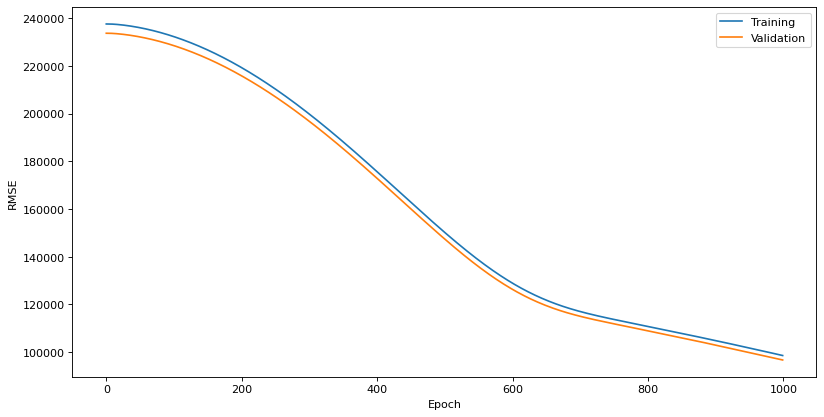

In [58]:
history = pipe.named_steps['keras'].history_
plot_rmse(history)

In [59]:
y_pred = pipe.predict(X_test)
metrics.root_mean_squared_error(y_test, y_pred)

41/41 [==============================] - 0s 1ms/step


96716.38835555186